# Three attributes game

Each action has 3 numerical atributes.  The three attributes are ranked for tiebreaking.  You win if your action is greater than the opponent's action in 2 out of 3 attributes.  In case that one attribute is tied, the tie is broken based on the rank of the winning attribute.

In the following, consider 3 non-negative integer attributes, each of which takes values {0, 1, 2, 3}.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# get all integer vectors with entries {0, ..., 5}
temp = np.ones((7, 7, 7))
vectors = np.array(np.nonzero(temp)).T
# restrict to vectors with sums in {5, .., 8}
sums = np.sum(vectors, 1)
vectors = vectors[np.logical_and(sums >= 5, sums <= 8)]
#vectors

In [3]:
# compute payoff sign matrix
a0_dom = np.sign(vectors[:, [0]] - vectors[:, [0]].T)
a1_dom = np.sign(vectors[:, [1]] - vectors[:, [1]].T)
a2_dom = np.sign(vectors[:, [2]] - vectors[:, [2]].T)

scores = 4 * (a0_dom > 0).astype(int) + 3 * (a1_dom > 0).astype(int) + 2 * (a2_dom > 0).astype(int)
win_mat = (scores > scores.T).astype(int)
p_sign = win_mat - win_mat.T



In [4]:
flag = True
# delete strictly dominating or dominant vectors
while flag:
    to_delete = np.logical_or(np.sum(p_sign == 1, 1) == 0, np.sum(p_sign == -1, 1) == 0)
    print(vectors[to_delete])
    vectors = vectors[~to_delete]
    p_sign = p_sign[~to_delete, :][:, ~to_delete]
    flag = (np.sum(to_delete) > 0)

[[0 0 5]]
[[0 0 6]]
[]


In [5]:
# function to form payoff matrix from signs and rewards
def form_payoff(p_sign, rewards):
    payoff = np.dot(np.diag(rewards), (p_sign==1))
    payoff = payoff - payoff.T
    return payoff

In [6]:
# tune rewards
n = len(vectors)
# desired nash equilibrium
target_p = np.ones(n)/n

def tune_rewards(p_sign, target_p, learning_rate = 0.002, n_iterations = 50000):
    # uniform rewards to begin
    rewards = np.ones(len(p_sign))
    # determine values of strategies
    # decrease the rewards of high-value strategies and increase the rewards of low-value strategies
    all_rewards = []
    all_values = []

    for iter_no in range(n_iterations):
        all_rewards.append(rewards)
        payoff = form_payoff(p_sign, rewards)
        values = np.dot(payoff, target_p)
        all_values.append(values)
        rewards = rewards - learning_rate * values

    all_rewards = np.array(all_rewards)
    all_values = np.array(all_values)
    return rewards, values, all_rewards, all_values

In [7]:
rewards, values, all_rewards, all_values = tune_rewards(p_sign, target_p)

In [8]:
for i in range(5):
    # filter out values with rewards much higher or lower than median
    np.median(rewards)
    filt = np.logical_and(rewards > 0.5 * np.median(rewards), rewards < 2 * np.median(rewards))
    vectors = vectors[filt]
    p_sign = p_sign[filt, :][:, filt]
    n = len(vectors)
    target_p = np.ones(n)/n
    print(n)
    rewards, values, all_rewards, all_values = tune_rewards(p_sign, target_p)

61
48
41
40
40


In [9]:
rewards, values, all_rewards, all_values = tune_rewards(p_sign, target_p)

In [10]:
np.sort(rewards)

array([0.52931487, 0.55420207, 0.55434226, 0.58602905, 0.60619588,
       0.61178942, 0.66610912, 0.68672973, 0.69980858, 0.70656505,
       0.7441743 , 0.74458738, 0.74617408, 0.80215088, 0.83905832,
       0.84212632, 0.85104022, 0.88021836, 0.91952325, 0.92206221,
       0.93245334, 0.96414974, 1.00514295, 1.0137711 , 1.09373688,
       1.10948678, 1.11444008, 1.14491553, 1.18906439, 1.22752238,
       1.23104257, 1.23287848, 1.23864521, 1.25332627, 1.3209441 ,
       1.54248781, 1.68826813, 1.72348691, 1.73491956, 1.74711645])

In [11]:
# discretize rewards
d_rewards = np.floor(rewards/np.min(rewards) * 2)
probs = np.ones(len(p_sign))/len(p_sign)
payoff = form_payoff(p_sign, d_rewards)
np.max(d_rewards)

6.0

In [12]:
def evolve_strategy(payoff, probs, learning_rate = 0.0005, n_iterations = 1000000):

    all_probs = []
    all_values = []

    for iter_no in range(n_iterations):
        all_probs.append(probs)
        #probs = np.mean(all_probs, 0)
        #print(probs)
        values = np.dot(payoff, probs)
        all_values.append(values)
        probs = probs * (1 + learning_rate * values)
        probs = probs/np.sum(probs)

    all_probs = np.array(all_probs)
    all_values = np.array(all_values)
    probs = np.mean(all_probs[int(n_iterations/2):, :], 0)
    values = np.dot(payoff, probs)
    return probs, values, all_probs, all_values

In [13]:
probs, values, all_probs, all_values = evolve_strategy(payoff, probs, 0.0001, 1000000)

In [14]:
np.max(values), np.min(values)

(0.013535194100737336, -0.6598351696039694)

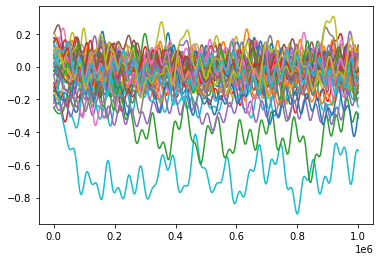

In [15]:
plt.plot(all_values)
plt.show()

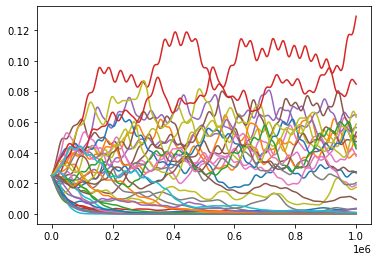

In [16]:
plt.plot(all_probs)
plt.show()

In [17]:
np.sum(probs > 0.01)

21

In [18]:
results = pd.DataFrame({
    'VP': d_rewards.astype(int), 
    'A0': vectors[:, 0], 'A1': vectors[:, 1], 'A2': vectors[:, 2], 
    'total': np.sum(vectors, 1),
    'prob': np.floor(probs* 1000)/10})
results.iloc[np.argsort(-probs)[:np.sum(probs > 0.001)], :].reset_index(drop = True)

,VP,A0,A1,A2,total,prob
0,3,3,0,4,7,10.2
1,3,4,2,0,6,8.2
2,4,3,1,2,6,6.7
3,3,1,5,1,7,6.5
4,3,3,3,0,6,5.7
5,2,0,4,4,8,5.6
6,6,1,2,3,6,5.3
7,3,6,0,1,7,4.7
8,4,0,3,4,7,4.7
9,4,2,5,0,7,4.7


In [20]:
#results.iloc[np.argsort(-probs), :].reset_index(drop = True).to_csv('three_attr_game_lage2.csv')

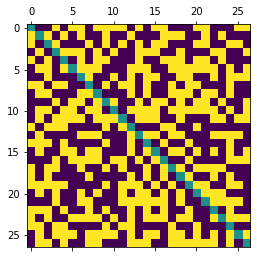

In [19]:
inds = np.argsort(-probs)[:np.sum(probs > 0.001)]
plt.matshow(p_sign[inds, :][:, inds])